In [1]:
import pyro
import torch
import normflows as nf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import yaml
import corner
import random
import pandas as pd
from collections import defaultdict
import numpy as np
mpl.rcParams["figure.dpi"] = 100

from grad_june import Runner

#torch.autograd.detect_anomaly(check_nan=True)

In [2]:
device = "cpu"

In [3]:
def set_random_seed(seed=999):
    """
    Sets global seeds for testing in numpy, random, and numbaized numpy.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return
#set_random_seed()

In [4]:
def plot_posterior(nfm, param_names, truths=None, lims=(0,2)):
    with torch.no_grad():
        samples, _ = nfm.sample(10000)
        samples = samples - 2.0
        samples = samples.cpu().numpy()
        f = corner.corner(samples, 
                          labels = param_names, 
                          smooth=2, 
                          show_titles=True,
                          bins=30,
                          truths=truths,
                          range = [lims for i in range(len(param_names))])
    #f.savefig(f"./flow_results/posteriors/posterior_{it:03d}.png", dpi=150, facecolor='white')
    return f

In [6]:
params = yaml.safe_load(open("../configs/tests.yaml"))

params["networks"]["school"]["log_beta"] = 0.5
params["networks"]["company"]["log_beta"] = 0.5
params["networks"]["care_home"]["log_beta"] = 0.5
params["networks"]["pub"]["log_beta"] = 0.5
params["networks"]["visit"]["log_beta"] = 0.5
params["networks"]["university"]["log_beta"] = 0.5

#params_to_calibrate = [name for name in params["networks"]] #["household", "school", "company"]#, "university", "care_home", "care_visit", "leisure"]
params_to_calibrate = ["household", "school", "company", "university", "care_home", "visit"]

true_values = [params["networks"][name]["log_beta"] for name in params_to_calibrate]
n_params = len(params_to_calibrate)
params["timer"]["total_days"] = 15
params["timer"]["initial_day"] = "2020-03-01"
params["system"]["device"] = device
#params["data_path"] = "../../data_camden.pkl"
#params["data_path"] = "/cosma7/data/dp004/dc-quer1/torch_june_worlds/data_camden.pkl"
params["data_path"] = "/Users/arnull/code/gradabm-june/worlds/data_camden.pkl"

runner = Runner.from_parameters(params)
true_res, _ = runner()
true_data = true_res['cases_per_timestep'] / runner.n_agents * 100

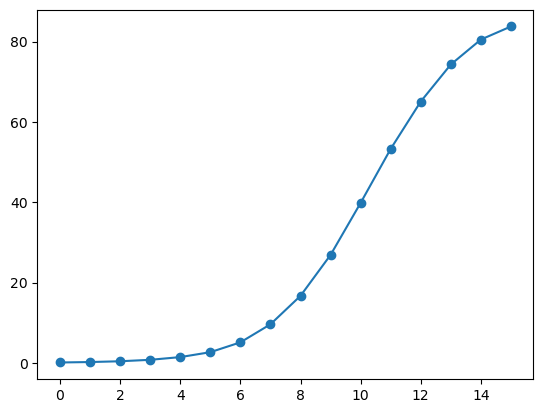

In [7]:
plt.plot(true_data.cpu(), "o-")
#plt.yscale("log")

In [8]:
prior = torch.distributions.Normal(torch.ones(n_params, device=device), torch.ones(n_params, device=device))

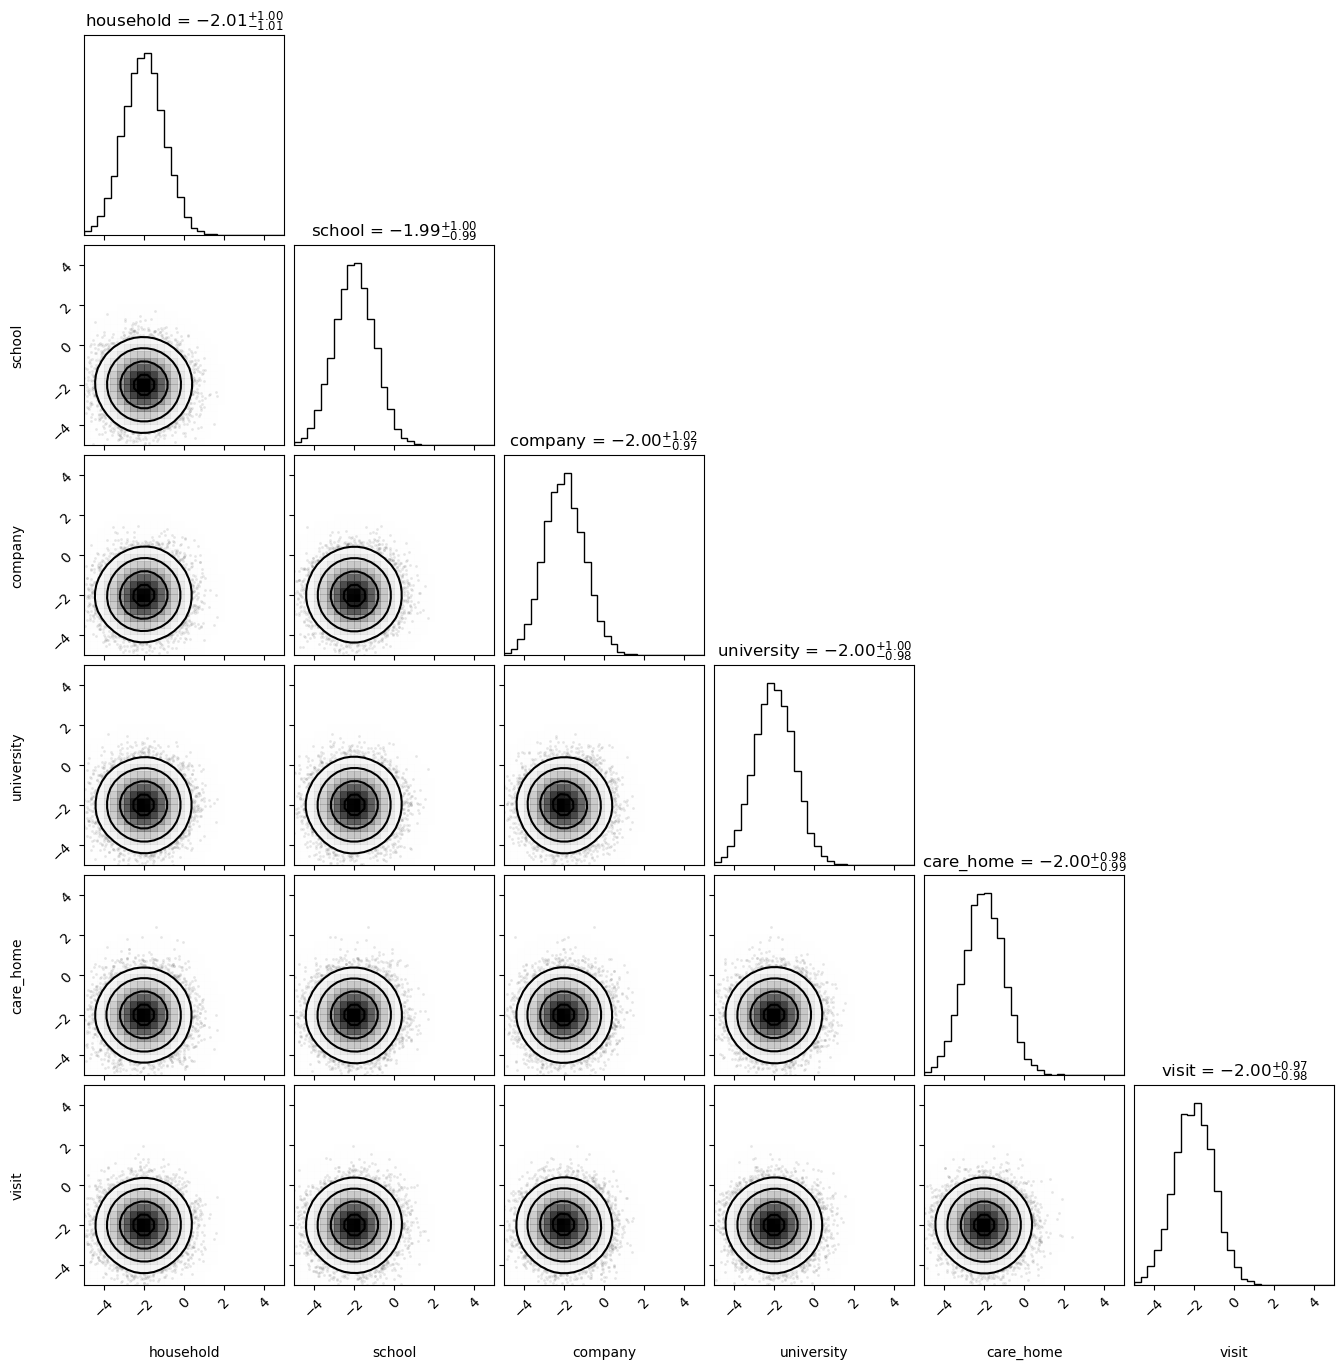

In [9]:
# Set up model

# Define flows
K = 4

latent_size = n_params
hidden_units = 16
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(n_params, trainable=False)

# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
flow = flow.to(device)

plot_posterior(flow, param_names = params_to_calibrate, lims=(-5, 5))
plt.show()

In [10]:
def run_model(runner, sample):
    #print(sample)
    sample = sample.flatten()
    for (j, name) in enumerate(params_to_calibrate):
        value_disp = sample[j] - 2.0
        if name == "log_fraction_initial_cases":
            runner.log_fraction_initial_cases = torch.minimum(torch.tensor(0.0), value_disp)
        elif name == "leisure":
            for _name in ["pub", "grocery", "gym", "cinema", "visit"]:
                runner.model.infection_networks.networks[_name].log_beta = value_disp
        else:
            runner.model.infection_networks.networks[name].log_beta = value_disp
    res,_ = runner()
    return res
    #cases = res["cases_per_timestep"] / runner.n_agents * 100
    #return cases

def get_forecast_score(flow, true_data, loss_fn, n_samples=5):
    loss = 0.0
    for i in range(n_samples):
        sample, lp = flow.sample()
        res = run_model(runner, sample)
        #loss_i = 0.0
        #for key in res:
            #if "age" in key:
            #    loss_i += loss_fn(true_res[key], res[key])
        loss_i = loss_fn(true_res["cases_per_timestep"], res["cases_per_timestep"])
        loss_i.backward()
        loss += loss_i
    return loss / n_samples

def get_regularisation(flow, n_samples=5):
    samples, flow_lps = flow.sample(n_samples)
    prior_lps = prior.log_prob(samples).sum(1)
    kl = torch.mean(flow_lps - prior_lps)
    return kl


In [11]:
losses = defaultdict(list)
best_loss = np.inf

In [ ]:
# Train model
n_epochs = 500

parameters_to_optimize = list(flow.parameters())
print(sum([len(a) for a in parameters_to_optimize]))
optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
loss_fn = torch.nn.MSELoss(reduction="mean")


n_samples_per_epoch = 5
n_samples_reg = 10


w = 0.0 #torch.tensor(1.0, requires_grad=True)

iterator = tqdm(range(n_epochs))

for it in iterator:
    optimizer.zero_grad()
    forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    loss = forecast_loss  + w * reglrise_loss
    losses["forecast_train"].append(forecast_loss.item())
    losses["reglrise_train"].append(reglrise_loss.item())
    #print(loss)
    if torch.isnan(loss):
        print("loss is nan!")
        break
    #loss.backward()

    optimizer.step()
    scheduler.step()
    if loss.item() < best_loss:
        torch.save(flow.state_dict(), "./best_model_data.pth")
        best_loss = loss.item()
    df = pd.DataFrame(losses)
    df.to_csv("./losses_data.csv")
    
    f = plot_posterior(flow, params_to_calibrate, truths=true_values, lims=(-5, 5))
    f.savefig(f"posteriors/posterior_{it:03d}.png", dpi=150, bbox_inches="tight")
    plt.close(f)

1912


 35%|██████████████████████████████████████████████████                                                                                              | 174/500 [1:18:48<1:50:16, 20.30s/it]

In [ ]:
flow.load_state_dict(torch.load("./best_model_data.pth"))

In [ ]:
plot_posterior(flow, params_to_calibrate, truths=true_values, lims=(-5, 5))

In [ ]:
n_plot = 10
fig, ax = plt.subplots()

for i in range(n_plot):
    with torch.no_grad():
        params["system"]["device"] = device
        #params["data_path"] = "../../data_camden.pkl"
        params["data_path"] = "/Users/arnull/code/gradabm-june/worlds/data_camden.pkl"
        runner = Runner.from_parameters(params)
        best_params_sample, log_prob = flow.sample()
        cases = run_model(runner, best_params_sample)
        ax.plot(cases.detach().cpu())

ax.plot(true_data.cpu(), color = "black", linewidth=2)
ax.set_yscale("log")